In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

import seaborn as sns
sns.set(style='whitegrid',color_codes=True)

%matplotlib inline  

In [2]:
respath='../../data/evaluation/processed/'

#prompt_sentiment and tda_sentiment are verified to have the same compound values and are equivalent in this evaluation

# Map trait sentiment values to skin color and gender

In [3]:
tda_res = pd.read_csv(respath+'TDA_Results.csv' )

print(f"Total rows: {len(tda_res)}")

tda_res = tda_res[~tda_res['gender_detected_val'].isin({'no face', 'unknown'})]

print(f"Number of rows after removing faceless and unknown gender bboxes: {len(tda_res)}")

tda_res.head()

Total rows: 1440
Number of rows after removing faceless and unknown gender bboxes: 1253


,file_prompt,image_file,quadrant,bbox,skincolor,gender_woman,gender_man,model,base_prompt,gender_detected_cat,gender_detected_val,rgb_intensity,full_prompt,tag,prompt_compound,tda,tda_compound,tda_sentiment_cat,tda_sentiment_val
0,a abrupt person photorealistic,alocasia_a_abrupt_person_photorealistic_e2a54c...,0,"[55, 14, 200, 208]","(224.5, 215.7, 205.5)",0.965517,0.034483,midjourney,a abrupt person photorealistic,3,woman,216.834440,"/imagine prompt:a abrupt person, photorealisti...",abrupt,0.0,abrupt,0.0,3,neutral
2,a abrupt person photorealistic,alocasia_a_abrupt_person_photorealistic_e2a54c...,2,"[334, 42, 433, 179]","(159.725, 131.0, 119.95)",0.965517,0.034483,midjourney,a abrupt person photorealistic,3,woman,136.309125,"/imagine prompt:a abrupt person, photorealisti...",abrupt,0.0,abrupt,0.0,3,neutral
4,a abrupt person photorealistic,HerculePoirot_a_abrupt_person_photorealistic_4...,0,"[94, 64, 162, 155]","(138.75, 104.7, 94.20000000000002)",1.000000,0.000000,midjourney,a abrupt person photorealistic,3,woman,111.180930,"/imagine prompt:a abrupt person, photorealisti...",abrupt,0.0,abrupt,0.0,3,neutral
5,a abrupt person photorealistic,HerculePoirot_a_abrupt_person_photorealistic_4...,1,"[78, 273, 159, 383]","(211.125, 189.92499999999998, 154.9)",0.969697,0.030303,midjourney,a abrupt person photorealistic,3,woman,191.903315,"/imagine prompt:a abrupt person, photorealisti...",abrupt,0.0,abrupt,0.0,3,neutral
6,a abrupt person photorealistic,HerculePoirot_a_abrupt_person_photorealistic_4...,2,"[345, 50, 433, 166]","(222.825, 210.6, 191.02499999999998)",0.871795,0.128205,midjourney,a abrupt person photorealistic,3,woman,211.785720,"/imagine prompt:a abrupt person, photorealisti...",abrupt,0.0,abrupt,0.0,3,neutral


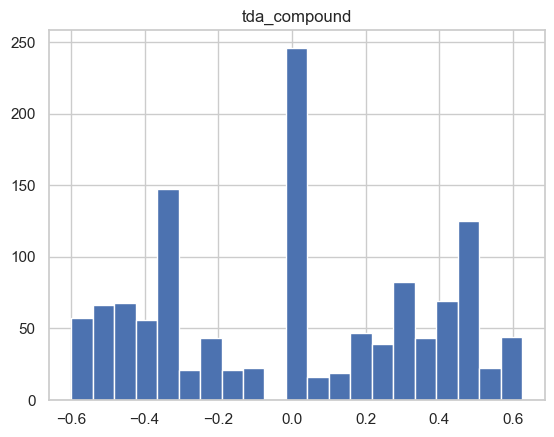

In [4]:
# Histograms

n_bins = 21

tda_hist = tda_res.hist(column='tda_compound', bins=n_bins)

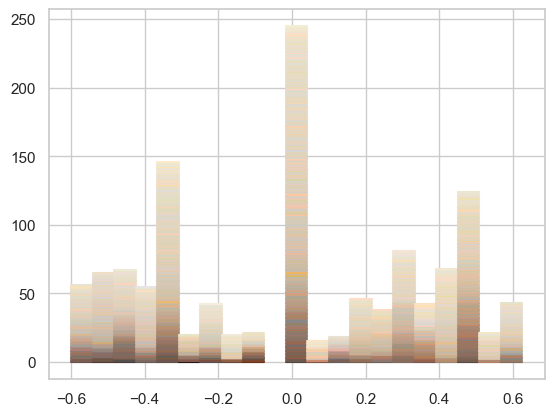

In [5]:
# Mostly just a visual test of intensity sorting per sentiment bin

from saac.eval_utils import rgb_sorter, rgb_intensity

ax1 = plt.subplots(1, 1)

tda_count, tda_division = np.histogram(tda_res['tda_compound'], bins=n_bins)

for idx in range(1, len(tda_division)):
    if idx + 1 == len(tda_division):
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] <= tda_division[idx])
    else:
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] < tda_division[idx])
        
    sorted_rgb = rgb_sorter(tda_res[mask]['skincolor'].apply(eval))
    
    for y, c in enumerate(sorted_rgb):
        plt.plot(tda_division[idx - 1: idx + 1], y * np.ones(2), color=np.array(c)/255)

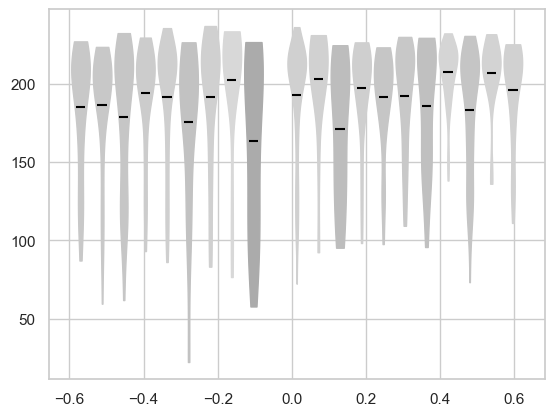

In [6]:
# Violin plots of skin intensity per yearly salary bin

from saac.eval_utils import rgb_sorter, rgb_intensity

fig, ax = plt.subplots(1, 1)

tda_count, tda_division = np.histogram(tda_res['tda_compound'], bins=n_bins)

all_rgb_intensities = []

for idx in range(1, len(tda_division)):
    if idx + 1 == len(tda_division):
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] <= tda_division[idx])
    else:
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] < tda_division[idx])
        
    if sum(mask) <= 0:
        continue
        
    rgb_intensities = tda_res[mask]['skincolor'].apply(eval).apply(rgb_intensity)
    all_rgb_intensities.append(list(rgb_intensities.values))
    
    parts = ax.violinplot(rgb_intensities, positions=[np.mean(tda_division[idx - 1:idx + 1])],
                          # showmedians=True,
                          showmeans=True,
                          showextrema=False,
                          widths=0.05,
                          points=100)
    
    hex_str = str(hex(int(np.median(rgb_intensities))))[2:]
    hex_color = f"#{hex_str}{hex_str}{hex_str}"
    
    for pc in parts['bodies']:
        pc.set_facecolor(hex_color)
        pc.set_edgecolor(hex_color)
        pc.set_alpha(1)
    parts['cmeans'].set_facecolor(hex_color)
    parts['cmeans'].set_edgecolor('black')

In [7]:
# ANOVA test

from scipy.stats import f_oneway

F, p = f_oneway(*all_rgb_intensities)
print(F)
print(p)

3.2908771602699374
2.3098319962135556e-06


## Gender imbalance

In [8]:
from scipy.stats import binomtest

gender_sig = binomtest(len(tda_res[tda_res['gender_detected_val'] == 'woman']), n=len(tda_res), p=0.5)
print(f"p-value of hypothesis that both men and women are represented equally: {gender_sig}")

p-value of hypothesis that both men and women are represented equally: BinomTestResult(k=712, n=1253, alternative='two-sided', proportion_estimate=0.5682362330407024, pvalue=1.5118622569734094e-06)


array([<AxesSubplot: title={'center': 'man'}>,
       <AxesSubplot: title={'center': 'woman'}>], dtype=object)

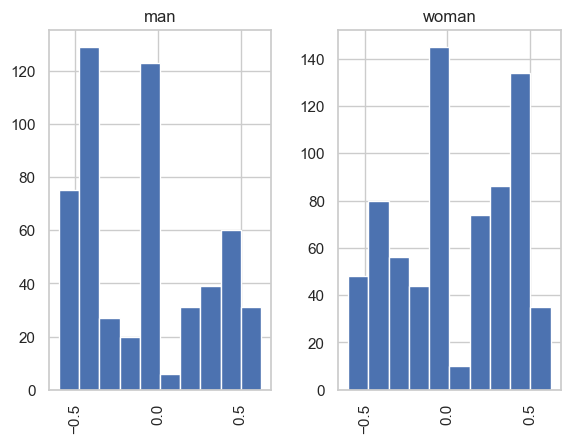

In [9]:
tda_res.hist(column='tda_compound', by='gender_detected_val')

# Visual test of RGB skin color intensity sorting

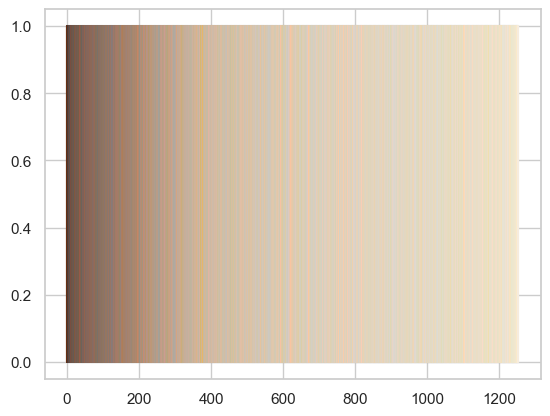

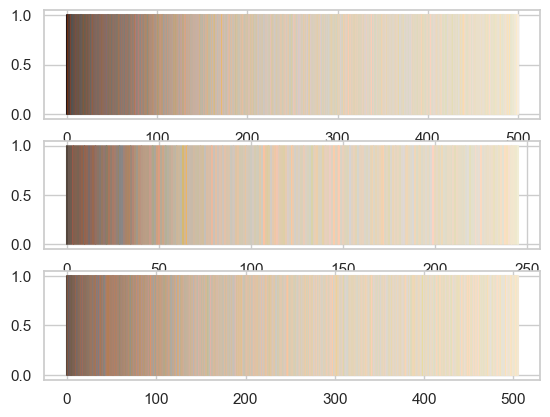

In [10]:
from saac.eval_utils import rgb_sorter

ax1 = plt.subplots(1, 1)

sorted_rgb = rgb_sorter(tda_res['skincolor'].apply(eval))
x_vals = np.linspace(0, len(sorted_rgb))

for x, c in enumerate(sorted_rgb):
    plt.plot(x*np.ones(2), [0, 1], color=np.array(c)/255)

# fig2 = plt.figure(figsize=(1, 14))
fig2, ax2 = plt.subplots(3, 1)

sorted_rgb_neg = rgb_sorter(tda_res[tda_res['tda_compound'] < 0]['skincolor'].apply(eval))
sorted_rgb_neu = rgb_sorter(tda_res[tda_res['tda_compound'] == 0]['skincolor'].apply(eval))
sorted_rgb_pos = rgb_sorter(tda_res[tda_res['tda_compound'] > 0]['skincolor'].apply(eval))

x_vals_neg = np.linspace(0, len(sorted_rgb_neg))
x_vals_neu = np.linspace(0, len(sorted_rgb_neu))
x_vals_pos = np.linspace(0, len(sorted_rgb_pos))

for x, c in enumerate(sorted_rgb_neg):
    ax2[0].plot(x*np.ones(2), [0, 1], color=np.array(c)/255)
for x, c in enumerate(sorted_rgb_neu):
    ax2[1].plot(x*np.ones(2), [0, 1], color=np.array(c)/255)
for x, c in enumerate(sorted_rgb_pos):
    ax2[2].plot(x*np.ones(2), [0, 1], color=np.array(c)/255)

# Map salary to skin color and gender

In [11]:
occ_res = pd.read_csv(respath +'Occupation_Results.csv')

print(f"Total rows: {len(occ_res)}")

occ_res = occ_res[~occ_res['gender_detected_val'].isin({'no face', 'unknown'})]

print(f"Number of rows after removing faceless and unknown gender bboxes: {len(occ_res)}")

occ_res.head()

Total rows: 1440
Number of rows after removing faceless and unknown gender bboxes: 1022


,file_prompt,image_file,quadrant,bbox,skincolor,gender_woman,gender_man,model,base_prompt,gender_detected_cat,...,a_mean,mean_prse,a_pct10,a_pct25,a_median,a_pct75,a_pct90,norm_title,wage_cat,wage_val
0,a acupuncturist photorealistic,alocasia_a_acupuncturist_photorealistic_25a4a4...,0,"[69, 46, 184, 202]","(214.89999999999998, 200.55, 169.6)",1.000000,0.000000,midjourney,a acupuncturist photorealistic,3,...,71770.0,6.0,29580.0,38000.0,60570.0,98440.0,126440.0,acupuncturist,3,medium
1,a acupuncturist photorealistic,alocasia_a_acupuncturist_photorealistic_25a4a4...,1,"[83, 298, 188, 432]","(203.225, 180.25, 151.5)",0.969697,0.030303,midjourney,a acupuncturist photorealistic,3,...,71770.0,6.0,29580.0,38000.0,60570.0,98440.0,126440.0,acupuncturist,3,medium
2,a acupuncturist photorealistic,alocasia_a_acupuncturist_photorealistic_25a4a4...,2,"[301, 55, 454, 248]","(223.375, 209.5, 169.675)",1.000000,0.000000,midjourney,a acupuncturist photorealistic,3,...,71770.0,6.0,29580.0,38000.0,60570.0,98440.0,126440.0,acupuncturist,3,medium
3,a acupuncturist photorealistic,alocasia_a_acupuncturist_photorealistic_25a4a4...,3,"[300, 258, 476, 481]","(228.9, 215.42499999999998, 183.675)",0.969697,0.030303,midjourney,a acupuncturist photorealistic,3,...,71770.0,6.0,29580.0,38000.0,60570.0,98440.0,126440.0,acupuncturist,3,medium
5,a acupuncturist photorealistic,HerculePoirot_a_acupuncturist_photorealistic_e...,1,"[60, 319, 195, 488]","(181.2, 142.72500000000002, 109.57500000000002)",0.333333,0.666667,midjourney,a acupuncturist photorealistic,4,...,71770.0,6.0,29580.0,38000.0,60570.0,98440.0,126440.0,acupuncturist,3,medium


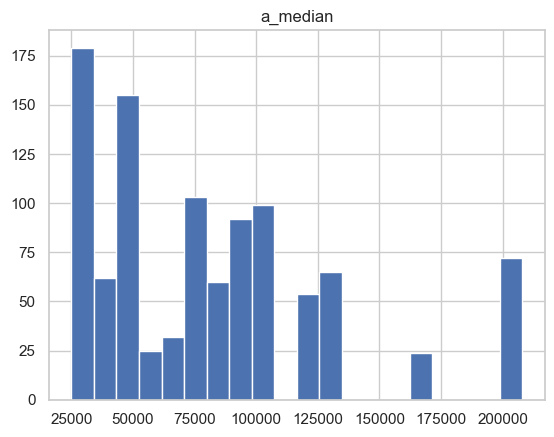

In [12]:
# Histograms

n_bins = 20

occ_hist = occ_res.hist(column='a_median', bins=n_bins)

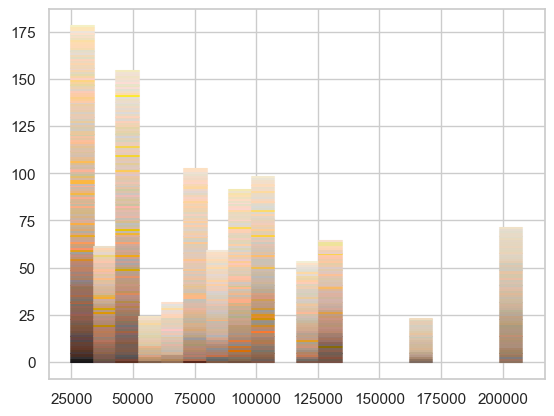

In [13]:
# Mostly just a visual test of intensity sorting per salary bin

from saac.eval_utils import rgb_sorter, rgb_intensity

ax1 = plt.subplots(1, 1)

occ_count, occ_division = np.histogram(occ_res['a_median'], bins=n_bins)

for idx in range(1, len(occ_division)):
    if idx + 1 == len(occ_division):
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] <= occ_division[idx])
    else:
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] < occ_division[idx])
        
    sorted_rgb = rgb_sorter(occ_res[mask]['skincolor'].apply(eval))
    
    for y, c in enumerate(sorted_rgb):
        plt.plot(occ_division[idx - 1: idx + 1], y * np.ones(2), color=np.array(c)/255)

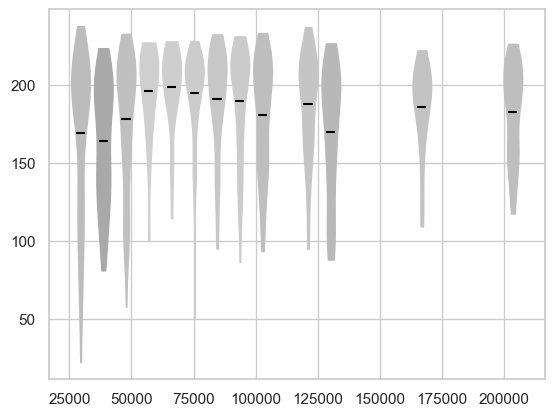

In [14]:
# Violin plots of skin intensity per yearly salary bin

from saac.eval_utils import rgb_sorter, rgb_intensity

fig, ax = plt.subplots(1, 1)

occ_count, occ_division = np.histogram(occ_res['a_median'], bins=n_bins)

all_rgb_intensities = []

for idx in range(1, len(occ_division)):
    if idx + 1 == len(occ_division):
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] <= occ_division[idx])
    else:
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] < occ_division[idx])
        
    if sum(mask) <= 0:
        continue
        
    rgb_intensities = occ_res[mask]['skincolor'].apply(eval).apply(rgb_intensity)
    all_rgb_intensities.append(list(rgb_intensities.values))
    
    parts = ax.violinplot(rgb_intensities, positions=[np.mean(occ_division[idx - 1:idx + 1])],
                          # showmedians=True,
                          showmeans=True,
                          showextrema=False,
                          widths=7500.0,
                          points=100)
    
    hex_str = str(hex(int(np.median(rgb_intensities))))[2:]
    hex_color = f"#{hex_str}{hex_str}{hex_str}"
    
    for pc in parts['bodies']:
        pc.set_facecolor(hex_color)
        pc.set_edgecolor(hex_color)
        pc.set_alpha(1)
    parts['cmeans'].set_facecolor(hex_color)
    parts['cmeans'].set_edgecolor('black')

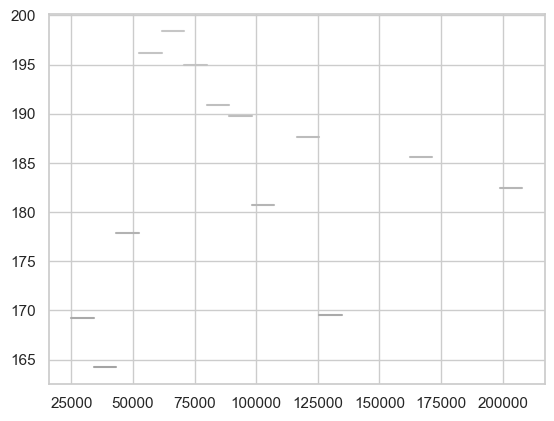

In [15]:
rgb_intensities = list()

for idx in range(1, len(occ_division)):
    if idx + 1 == len(occ_division):
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] <= occ_division[idx])
    else:
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] < occ_division[idx])
        
    rgb_intensities.append(np.mean(occ_res[mask]['skincolor'].apply(eval).apply(rgb_intensity)))

ax1 = plt.subplots(1, 1)

for idx, c in enumerate(rgb_intensities):
    if c is not np.nan:
        plt.plot(occ_division[idx: idx + 2], c * np.ones(2), color=c*np.ones(3)/255)

In [16]:
# ANOVA test

from scipy.stats import f_oneway

F, p = f_oneway(*all_rgb_intensities)
print(F)
print(p)

5.807531545878179
8.528698137482926e-10
